In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import time
import missingno as msno
import matplotlib.dates as mdates
import pickle
import datetime


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, roc_auc_score, average_precision_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             make_scorer)


!pip install scikit-plot
import scikitplot as skplt



In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Accidents/Data
!ls "/content/drive/My Drive/Colab Notebooks/Data/"
Data_Folder_Name="/content/drive/My Drive/Accidents/Data/"

Mounted at /content/drive
acc_cat.pkl
acc_enc.pkl
acc_rf.pkl
acc_veh_cat.pkl
dft-road-casualty-statistics-accident-1979-2021.csv
dft-road-casualty-statistics-casualty-1979-2021.csv
dft-road-casualty-statistics-vehicle-1979-2021.csv
dft-road-casualty-statistics-vehicle-2020.csv
dft-road-casualty-statistics-vehicle-2021.csv
rf_best_071603.pkl
rf_best_071711.pkl
rf_best_071720.pkl
rf_best_071723.pkl
rf_uc_072110.pkl
Road-Safety-Open-Dataset-Data-Guide.xlsx
dft-road-casualty-statistics-accident-2020.csv
dft-road-casualty-statistics-casualty-2020.csv
dft-road-casualty-statistics-vehicle-2020.csv
Road-Safety-Open-Dataset-Data-Guide.xlsx


In [3]:
### The full dataset was prepared in Data Reduction.ipynb at: https://github.com/KavehVasei/Capstone2-UK-Road-Safty/blob/main/DataReduction.ipynb
df_cat = pd.read_pickle("./drive/MyDrive/Accidents/Data/acc_veh_cat.pkl")
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278143 entries, 2 to 308585
Data columns (total 40 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_year                                278143 non-null  int32  
 1   longitude                                    278143 non-null  float64
 2   latitude                                     278143 non-null  float64
 3   police_force                                 278143 non-null  uint8  
 4   accident_severity                            278143 non-null  uint8  
 5   number_of_vehicles                           278143 non-null  uint8  
 6   number_of_casualties                         278143 non-null  uint8  
 7   day_of_week                                  278143 non-null  uint8  
 8   first_road_class                             278143 non-null  uint8  
 9   road_type                                    278143 non-nul

In [4]:
df_cat.nunique()

accident_year                                       3
longitude                                      265900
latitude                                       260543
police_force                                       52
accident_severity                                   3
number_of_vehicles                                  5
number_of_casualties                                5
day_of_week                                         7
first_road_class                                    6
road_type                                           6
speed_limit                                         6
junction_detail                                    10
pedestrian_crossing_human_control                   4
pedestrian_crossing_physical_facilities             7
light_conditions                                    5
weather_conditions                                  9
road_surface_conditions                             6
special_conditions_at_site                          9
carriageway_hazards         

In [5]:
### classify cols characteristics

# to be dropped for ML
outofX=['accident_severity','day_of_week','hour','accident_level']

#numerical Features
numcols=['accident_year','longitude','latitude','speed_limit']

#Categorical:     binary columns
binarycols=['urban_or_rural_area','did_police_officer_attend_scene_of_accident','weekend','covid']

#Categorical:     Ordinal Columns  # treat like numerics
ordinals=['number_of_vehicles','number_of_casualties','smallest_veh','biggest_vel','towing','restricted',
          'skidding','jacknifed','overturned','xcenterguard','rebounded','male_drivers','female_drivers']


#Categorical:     Nominal Columns
nominals=['police_force','first_road_class','road_type','junction_detail','pedestrian_crossing_human_control',
          'pedestrian_crossing_physical_facilities','light_conditions','weather_conditions','road_surface_conditions',
          'special_conditions_at_site','carriageway_hazards','trunk_road_flag','month','time_of_day','junction_location']

df_cat[nominals] = df_cat[nominals].astype('category')

df_cat.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 278143 entries, 2 to 308585
Data columns (total 40 columns):
 #   Column                                       Non-Null Count   Dtype   
---  ------                                       --------------   -----   
 0   accident_year                                278143 non-null  int32   
 1   longitude                                    278143 non-null  float64 
 2   latitude                                     278143 non-null  float64 
 3   police_force                                 278143 non-null  category
 4   accident_severity                            278143 non-null  uint8   
 5   number_of_vehicles                           278143 non-null  uint8   
 6   number_of_casualties                         278143 non-null  uint8   
 7   day_of_week                                  278143 non-null  uint8   
 8   first_road_class                             278143 non-null  category
 9   road_type                                    278

In [6]:
# Target Imbalance:
print('imbalance ratio: ',round(df_cat.accident_level.value_counts()[0]/df_cat.accident_level.value_counts()[1],2),"to 1  ,  with ",
                          round(100*df_cat.accident_level.value_counts()[1]/len(df_cat),2),"% being Major accidents and the rest Minor")
df_cat.accident_level.value_counts()

imbalance ratio:  3.35 to 1  ,  with  22.97 % being Major accidents and the rest Minor


0    214242
1     63901
Name: accident_level, dtype: int64


**df_cat above is categorical data set:**

When using RandomForestClassifier or some other clf models, you can pass the categorical variables directly to the classifier without one-hot encoding. It is important to ensure that the categorical variables are properly encoded as integers or categorical data types in the input data.

**We also make a onehot encoded (dummy version actually)  as df_encoded:**


In [7]:
# Perform one-hot encoding on the nominal columns
df_encoded = pd.get_dummies(df_cat[nominals])

# Concatenate the encoded columns with the remaining columns
df_encoded = pd.concat([df_cat.drop(nominals, axis=1), df_encoded], axis=1)
df_encoded.head(2).T

,2,3
accident_year,2019.000000,2019.000000
longitude,-0.124193,-0.191044
latitude,51.526795,51.546387
accident_severity,3.000000,2.000000
number_of_vehicles,2.000000,1.000000
...,...,...
junction_location_4,0.000000,0.000000
junction_location_5,0.000000,0.000000
junction_location_6,0.000000,0.000000
junction_location_7,0.000000,0.000000


In [8]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278143 entries, 2 to 308585
Columns: 174 entries, accident_year to junction_location_8
dtypes: float64(2), int32(1), uint8(171)
memory usage: 52.8 MB


### Train Vlidation and test sets

In [9]:
Xc = df_cat.drop(['accident_level','accident_severity'], axis=1)
yc = df_cat['accident_level']

# Split the data into train and test sets
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.15, stratify=yc, random_state=82)

# Further split the train set into train and validation sets
Xc_train, Xc_val, yc_train, yc_val = train_test_split(Xc_train, yc_train, test_size=0.15, stratify=yc_train, random_state=82)


print( f"Shapes of the datasets with multi label categories: \n")
print("Train set shape:", Xc_train.shape, yc_train.shape)
print("Validation set shape:", Xc_val.shape, yc_val.shape)
print("Test set shape:", Xc_test.shape, yc_test.shape)



Xe = df_encoded.drop(['accident_level','accident_severity'], axis=1)
ye = df_encoded['accident_level']

# Split the data into train and test sets
Xe_train, Xe_test, ye_train, ye_test = train_test_split(Xe, ye, test_size=0.15, stratify=ye, random_state=82)

# Further split the train set into train and validation sets
Xe_train, Xe_val, ye_train, ye_val = train_test_split(Xe_train, ye_train, test_size=0.15, stratify=ye_train, random_state=82)


print( f"\n\n Shapes of the Encoded datasets: \n")
print("Train set shape:", Xe_train.shape, ye_train.shape)
print("Validation set shape:", Xe_val.shape, ye_val.shape)
print("Test set shape:", Xe_test.shape, ye_test.shape)


Shapes of the datasets with multi label categories: 

Train set shape: (200957, 38) (200957,)
Validation set shape: (35464, 38) (35464,)
Test set shape: (41722, 38) (41722,)


 Shapes of the Encoded datasets: 

Train set shape: (200957, 172) (200957,)
Validation set shape: (35464, 172) (35464,)
Test set shape: (41722, 172) (41722,)


### Dataset Imbalance Strategies:

**Here I check three ways to handle imbalance:**

**1- undersampling**

**2-oversampling Using SMOTE**

**3-using balance weights in rf_clf : (feading Xc or Xe directly)**

In [10]:
# UnderSampling
from imblearn.under_sampling import RandomUnderSampler

# Create the RandomUnderSampler object
undersampler = RandomUnderSampler(random_state=82)

# Apply undersampling on X_train and y_train for both cat and ohe dataframes
Xc_train_us, yc_train_us = undersampler.fit_resample(Xc_train, yc_train)  # categorical only train set

Xe_train_us, ye_train_us = undersampler.fit_resample(Xe_train, ye_train)  # encoded only train set

#after finetuning the best model we can do it for whole dataset for unseen data

# class distribution before
print("Initial Class distribution :")
print(yc_train.value_counts())
print(ye_train.value_counts())
# Verify the class distribution after undersampling
print("Class distribution after undersampling:")
print(yc_train_us.value_counts())
print(ye_train_us.value_counts())


Initial Class distribution :
0    154789
1     46168
Name: accident_level, dtype: int64
0    154789
1     46168
Name: accident_level, dtype: int64
Class distribution after undersampling:
0    46168
1    46168
Name: accident_level, dtype: int64
0    46168
1    46168
Name: accident_level, dtype: int64


In [11]:
#from imblearn.over_sampling import SMOTE

# Create the SMOTE object
smote = SMOTE(random_state=82)

# Apply SMOTE on X_train and y_train
Xc_train_os, yc_train_os = smote.fit_resample(Xc_train, yc_train)   ## This produces a lot of nan values can't be used
print("Number of nan generated values for Xc: ",Xc_train_os.isna().sum().sum())
#so for smote we only use encoded values here

Xe_train_os, ye_train_os = smote.fit_resample(Xe_train, ye_train)
print("Number of nan generated values foe Xe: ",Xe_train_os.isna().sum().sum())


# Verify the class distribution after oversampling
print("Class distribution after oversampling:")
print(ye_train_os.value_counts())

Number of nan generated values for Xc:  359511
Number of nan generated values foe Xe:  0
Class distribution after oversampling:
0    154789
1    154789
Name: accident_level, dtype: int64


### functions for evaluation and models

In [12]:
# Here is a function to perform a quick evaluation of each model:
def evaluate_classifier(model, X_test, y_test,index = ['Actual Minor_Acc', 'Actual Major_Acc' ]):

    """
    Takes a model and its test data.
    Prints and returns model metrics.
    """

    # get predictions
    y_pred = model.predict(X_test)

    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # compute Area under the curve
    roc_auc = roc_auc_score(y_test, y_pred)

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # plot ROC curve
    title = 'ROC Curve:  AUC =' + str(roc_auc.round(3))
    _ = plt.figure(figsize=(5,5))
    _ = plt.plot(fpr, tpr)
    _ = plt.plot([0,1], [0,1], 'k--')
    _ = plt.xlabel('False Positive Rate (FPR)')
    _ = plt.ylabel('True Positive Rate (TPR)')
    _ = plt.title(title)
    _ = plt.legend(['predictive power','random vector'])
    # show plot when function is called, plot not returned
    plt.show()


    # construct confusion matrix
    #conf_matrx = pd.DataFrame(confusion_matrix(y_test, y_pred))
    #conf_matrx.columns = ['Predict: NO', 'Predict: YES']
    #conf_matrx.index = ['Actual: NO', 'Actual: YES']

    conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index = index,
                           columns = [f'predicted \n Minor', f'predicted \n Major'])

    conf_matrix

    # get classification report
    report = classification_report(y_test, y_pred)
    print(report)
    return conf_matrix, report


# Here is a function to perform a quick evaluation of each model:
def ROC_PRC(model, X_test, y_test,index = ['Actual Minor_Acc', 'Actual Major_ACC' ]):

    y_pred_prob = rf_best.predict_proba(X_test)

    #plot roc curve and  print AUC score
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    skplt.metrics.plot_roc(y_test, y_pred_prob, ax=axes[0])
    axes[0].set_title('ROC Curve - Categorical Version')
    skplt.metrics.plot_precision_recall(y_test, y_pred_prob, ax=axes[1])
    axes[1].set_title('Precision-Recall Curve  - Categorical Version')
    plt.tight_layout()
    plt.show()
    auc_score = roc_auc_score(y_test, y_pred_prob[:,1])
    auprc_score = average_precision_score(y_test, y_pred_prob[:, 1])
    print('AUC score:  {}         AUPRC score:  {}'.format(auc_score,auprc_score))

    return auc_score, auprc_score



In [21]:
#stop

In [ ]:
#Sample Run Steps

## Under_Sampling with one hot encoded categorical data
*** as here we have balanced data i experiment with accuracy rather than f1 ***

In [41]:
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xe_train_us
y_train=ye_train_us
X_test=Xe_val
y_test=ye_val

# Define the F1 score scorer for the 'Major' class
scorer = make_scorer(f1_score, pos_label='Major')
scorers = {
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score),
}
# ...

rf_imbal = RandomForestClassifier(class_weight='balanced')
parameters_rf = {
    'n_estimators': [300],# 200],
    'criterion': ["gini"], # "entropy"],
    'max_depth': [100],#50],# 12],
    'max_features': ['sqrt']#,'log2']
}
rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorers, n_jobs=-1, refit='accuracy')  #using accuracy

#rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorer, n_jobs=-1)
t0 = time.time()
rf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", rf_clf.best_params_)

cv_results = rf_clf.cv_results_

# Print the scores for each hyperparameter combination
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))


rf_best = rf_clf.best_estimator_


It takes 523.329 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 300}
Hyperparameters: {'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 300}
   f1_score: 0.660 (+/-0.003)
   precision: 0.647 (+/-0.006)
   recall: 0.673 (+/-0.005)
   accuracy: 0.653 (+/-0.005)
   auc: 0.653 (+/-0.005)
   auprc: 0.599 (+/-0.004)


In [42]:
rf_clf.cv_results_

{'mean_fit_time': array([137.77165051]),
 'std_fit_time': array([23.63150144]),
 'mean_score_time': array([4.30704312]),
 'std_score_time': array([0.65351149]),
 'param_criterion': masked_array(data=['gini'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['sqrt'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[300],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini',
   'max_depth': 100,
   'max_features': 'sqrt',
   'n_estimators': 300}],
 'split0_test_f1_score': array([0.6646062]),
 'split1_test_f1_score': array([0.65577055]),
 'split2_test_f1_score': array([0.65973862]),
 'split3_test_f1_score': array([0.65596404]),
 'split4_test_f1_score': array([0.66

In [44]:
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"rf_ue_accuracy_{timestamp}.pkl"
print(file_name)
with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(rf_best, file)


rf_ue_accuracy_072119.pkl


In [ ]:
# load the model filename=?   # saved model rf_uc_072110.pkl
file_name = "rf_ue_accuracy_072119.pkl"
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xc_train_us
y_train=yc_train_us
X_test=Xc_val
y_test=yc_val

with open("./drive/MyDrive/Accidents/Data/"+file_name, 'rb') as file:
    rf_best = pickle.load(file)

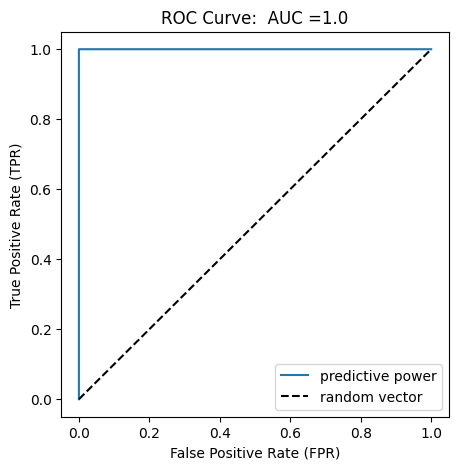

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46168
           1       1.00      1.00      1.00     46168

    accuracy                           1.00     92336
   macro avg       1.00      1.00      1.00     92336
weighted avg       1.00      1.00      1.00     92336



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,46168,0
Actual Major_Acc,1,46167


In [45]:
#check performance on train set !!!
matrix, report = evaluate_classifier(rf_best, X_train, y_train)
matrix

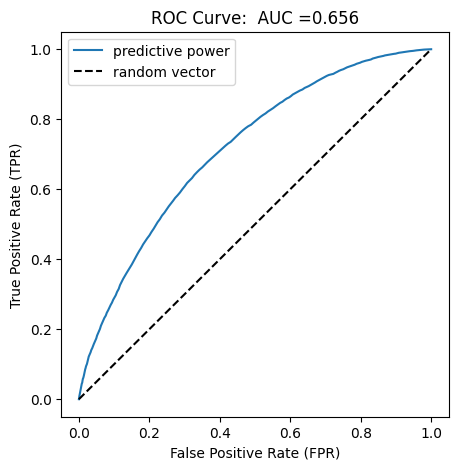

              precision    recall  f1-score   support

           0       0.87      0.64      0.73     27316
           1       0.36      0.68      0.47      8148

    accuracy                           0.65     35464
   macro avg       0.61      0.66      0.60     35464
weighted avg       0.75      0.65      0.67     35464



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,17369,9947
Actual Major_Acc,2632,5516


In [46]:
matrix, report = evaluate_classifier(rf_best, X_test, y_test)
matrix

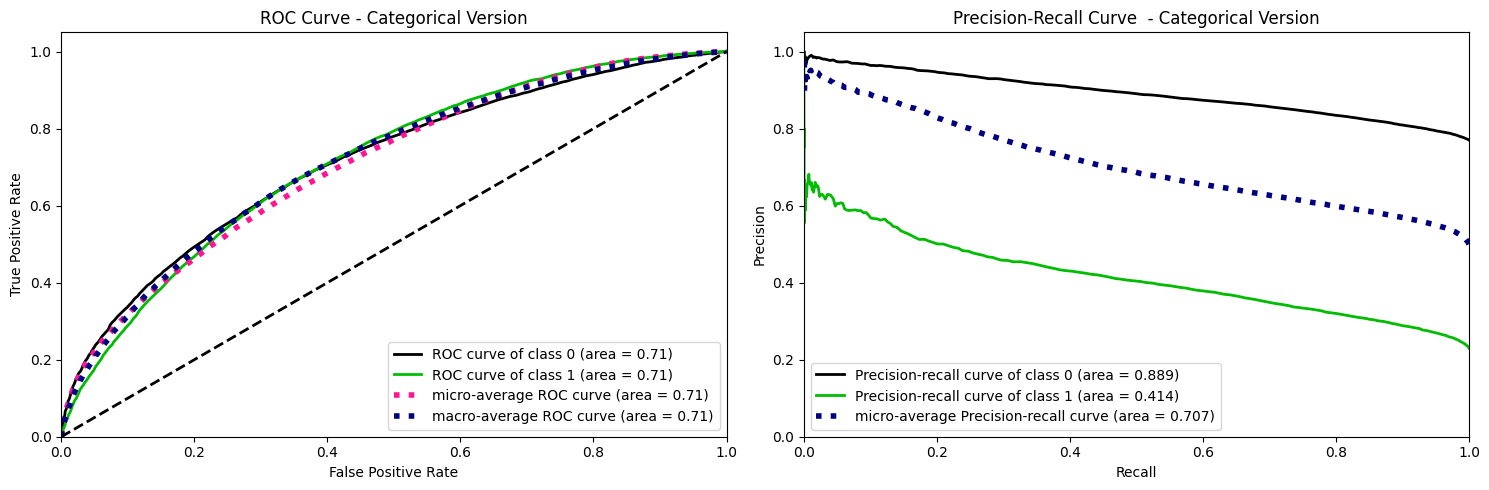

AUC score:  0.7149066830734933         AUPRC score:  0.41425880460083103


(0.7149066830734933, 0.41425880460083103)

In [47]:
ROC_PRC(rf_best, X_test, y_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'latitude'),
  Text(1, 0, 'longitude'),
  Text(2, 0, 'hour'),
  Text(3, 0, 'day_of_week'),
  Text(4, 0, 'smallest_veh'),
  Text(5, 0, 'speed_limit'),
  Text(6, 0, 'biggest_vel'),
  Text(7, 0, 'accident_year'),
  Text(8, 0, 'number_of_casualties'),
  Text(9, 0, 'number_of_vehicles'),
  Text(10, 0, 'male_drivers'),
  Text(11, 0, 'female_drivers'),
  Text(12, 0, 'covid'),
  Text(13, 0, 'did_police_officer_attend_scene_of_accident'),
  Text(14, 0, 'first_road_class_3'),
  Text(15, 0, 'first_road_class_6'),
  Text(16, 0, 'weekend'),
  Text(17, 0, 'time_of_day_3'),
  Text(18, 0, 'skidding'),
  Text(19, 0, 'urban_or_rural_area')])

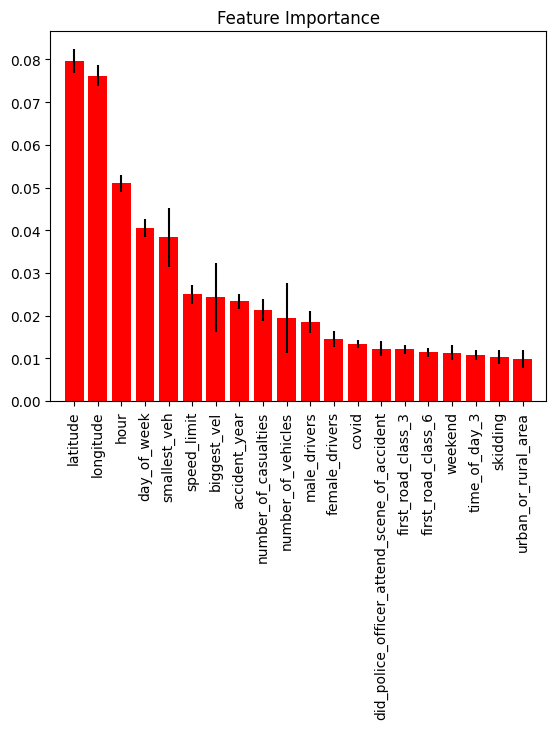

In [48]:
skplt.estimators.plot_feature_importances(rf_best, feature_names= list(X_train.columns))
plt.xticks(rotation=90)

## Under_Sampling with categorical data
*** used f1_score for selecting best model ***

In [ ]:
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xc_train_us
y_train=yc_train_us
X_test=Xc_val
y_test=yc_val

scorers = {
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score),
}

rf = RandomForestClassifier()#class_weight='balanced')
parameters_rf = {
    'n_estimators': [600],#1000],
    'criterion': ["gini"], # "entropy"],
    'max_depth': [400],#150],
    'max_features': ['sqrt']#,'log2']
}

rf_clf = GridSearchCV(rf, param_grid=parameters_rf, cv=5, scoring=scorers, n_jobs=-1, refit='f1_score')  #using f1 on 1

t0 = time.time()
rf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", rf_clf.best_params_)

cv_results = rf_clf.cv_results_

# Print the scores for each hyperparameter combination
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))


rf_best = rf_clf.best_estimator_



In [ ]:
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"rf_uc_{timestamp}.pkl"
print(file_name)

with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(rf_best, file)


In [52]:
# load the model rf_uc_072110.pkl
file_name = "rf_uc_072110.pkl"
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xc_train_us
y_train=yc_train_us
X_test=Xc_val
y_test=yc_val


with open("./drive/MyDrive/Accidents/Data/"+file_name, 'rb') as file:
    rf_best = pickle.load(file)



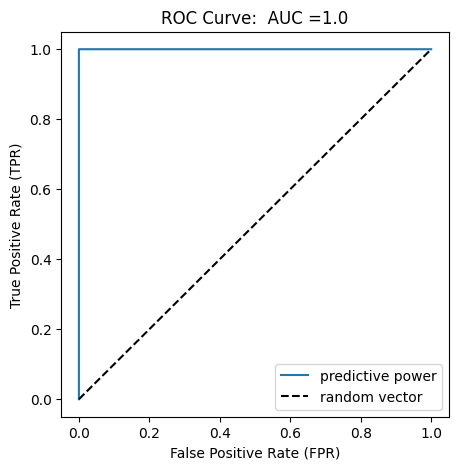

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46168
           1       1.00      1.00      1.00     46168

    accuracy                           1.00     92336
   macro avg       1.00      1.00      1.00     92336
weighted avg       1.00      1.00      1.00     92336



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,46167,1
Actual Major_Acc,0,46168


In [53]:
matrix, report = evaluate_classifier(rf_best, X_train, y_train)
matrix

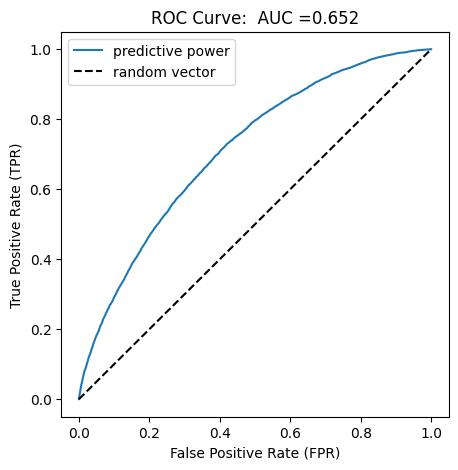

              precision    recall  f1-score   support

           0       0.87      0.63      0.73     27316
           1       0.35      0.68      0.46      8148

    accuracy                           0.64     35464
   macro avg       0.61      0.65      0.60     35464
weighted avg       0.75      0.64      0.67     35464



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,17203,10113
Actual Major_Acc,2648,5500


In [54]:
matrix, report = evaluate_classifier(rf_best, X_test, y_test)
matrix

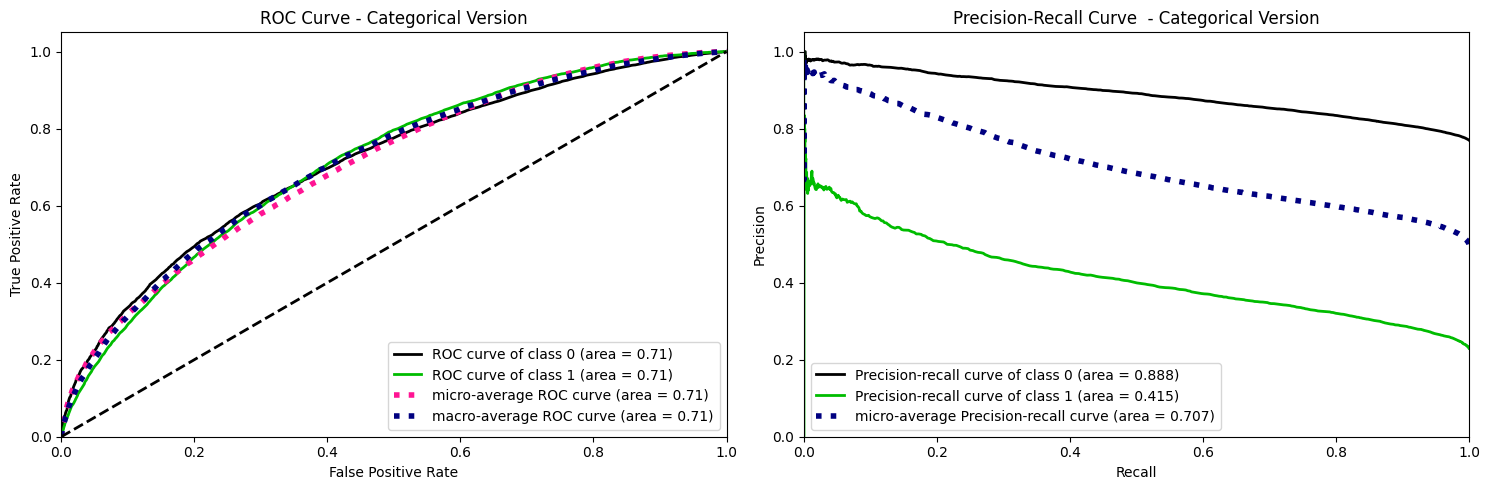

AUC score:  0.7125541324456408         AUPRC score:  0.4152555282267091


(0.7125541324456408, 0.4152555282267091)

In [55]:
ROC_PRC(rf_best, X_test, y_test)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'latitude'),
  Text(1, 0, 'longitude'),
  Text(2, 0, 'hour'),
  Text(3, 0, 'month'),
  Text(4, 0, 'police_force'),
  Text(5, 0, 'day_of_week'),
  Text(6, 0, 'smallest_veh'),
  Text(7, 0, 'junction_detail'),
  Text(8, 0, 'junction_location'),
  Text(9, 0, 'first_road_class'),
  Text(10, 0, 'speed_limit'),
  Text(11, 0, 'accident_year'),
  Text(12, 0, 'biggest_vel'),
  Text(13, 0, 'time_of_day'),
  Text(14, 0, 'number_of_casualties'),
  Text(15, 0, 'weather_conditions'),
  Text(16, 0, 'male_drivers'),
  Text(17, 0, 'number_of_vehicles'),
  Text(18, 0, 'pedestrian_crossing_physical_facilities'),
  Text(19, 0, 'road_type')])

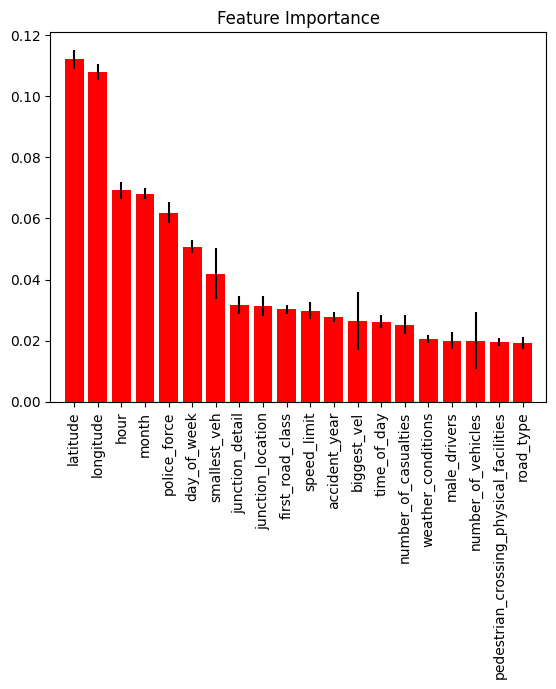

In [56]:
skplt.estimators.plot_feature_importances(rf_best, feature_names= list(X_train.columns))
plt.xticks(rotation=90)

<BarContainer object of 38 artists>

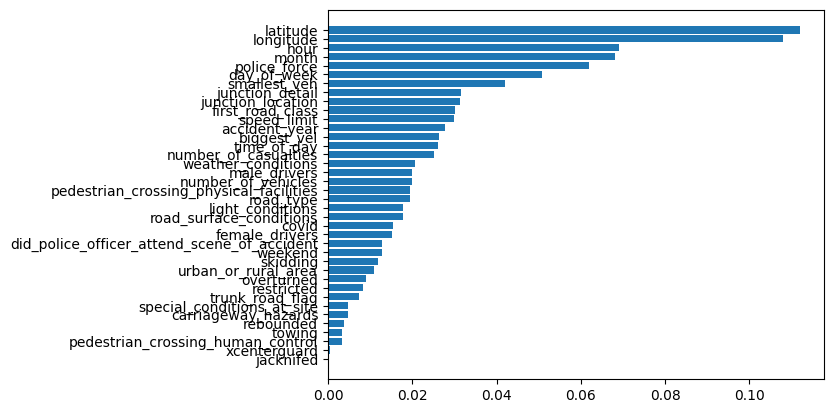

In [57]:
features, values = X_train.columns, rf_best.feature_importances_
feature_importances = list(zip(features, values))
feature_importances = sorted(feature_importances, key = lambda x: x[1])
features_sorted, importances_sorted = zip(*feature_importances)
plt.barh(features_sorted, importances_sorted)


#oversampling

In [17]:
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xe_train_os
y_train=ye_train_os
X_test=Xe_val
y_test=ye_val

#Define the F1 score scorer for the 'Major accidents ' class
scorer = make_scorer(f1_score, pos_label=1)
scorers = {
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score),
}

rf = RandomForestClassifier()#class_weight='balanced')
parameters_rf = {
    'n_estimators': [100],#1000],
    'criterion': ["gini"], # "entropy"],
    'max_depth': [50],#150,# 12],
    'max_features': ['sqrt']#,'log2']
}

rf_clf = GridSearchCV(rf, param_grid=parameters_rf, cv=3, scoring=scorers, n_jobs=-1, refit='f1_score')  #using accuracy

t0 = time.time()
rf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", rf_clf.best_params_)

cv_results = rf_clf.cv_results_

# Print the scores for each hyperparameter combination
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))


rf_best = rf_clf.best_estimator_


It takes 389.516 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 100}
Hyperparameters: {'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 100}
   f1_score: 0.719 (+/-0.294)
   precision: 0.902 (+/-0.039)
   recall: 0.719 (+/-0.381)
   accuracy: 0.810 (+/-0.159)
   auc: 0.810 (+/-0.159)
   auprc: 0.774 (+/-0.135)


In [18]:
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"rf_oe_{timestamp}.pkl"
print(file_name)
with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(rf_best, file)


rf_oe_072117.pkl


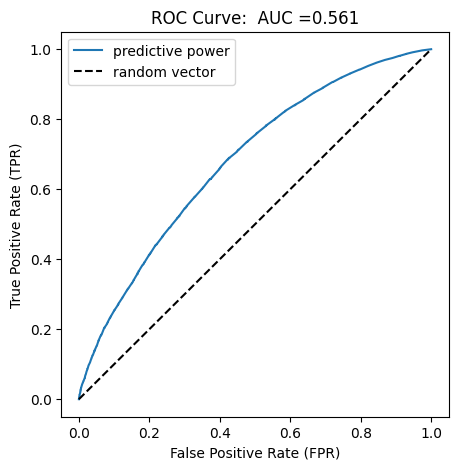

              precision    recall  f1-score   support

           0       0.79      0.94      0.86     27316
           1       0.46      0.19      0.27      8148

    accuracy                           0.76     35464
   macro avg       0.63      0.56      0.56     35464
weighted avg       0.72      0.76      0.72     35464



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,25542,1774
Actual Major_Acc,6631,1517


In [19]:
# saved model rf_oe_072117.pkl

matrix, report = evaluate_classifier(rf_best, X_test, y_test)
matrix

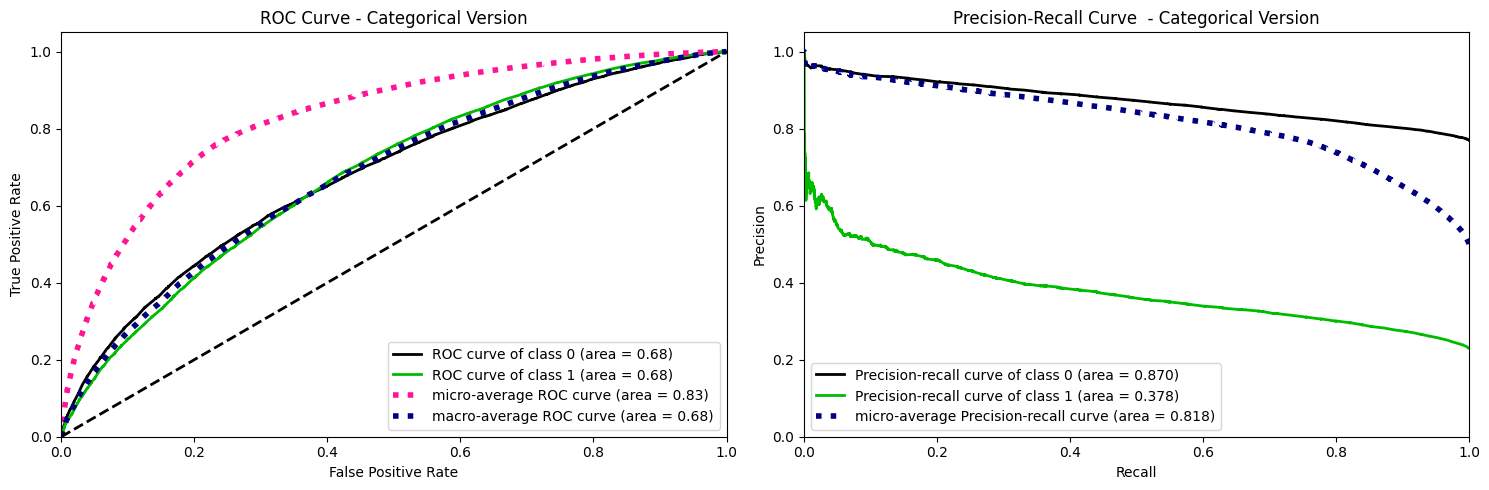

AUC score:  0.6802854452117449         AUPRC score:  0.3776189563647312


(0.6802854452117449, 0.3776189563647312)

In [20]:
ROC_PRC(rf_best, X_test, y_test)


In [22]:
rf_clf.cv_results_

{'mean_fit_time': array([131.66533677]),
 'std_fit_time': array([18.96112475]),
 'mean_score_time': array([6.98600833]),
 'std_score_time': array([0.94083238]),
 'param_criterion': masked_array(data=['gini'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[50],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['sqrt'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini',
   'max_depth': 50,
   'max_features': 'sqrt',
   'n_estimators': 100}],
 'split0_test_f1_score': array([0.30342668]),
 'split1_test_f1_score': array([0.92773804]),
 'split2_test_f1_score': array([0.92665363]),
 'mean_test_f1_score': array([0.71927278]),
 'std_test_f1_score': array([0.29404793

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'latitude'),
  Text(1, 0, 'smallest_veh'),
  Text(2, 0, 'longitude'),
  Text(3, 0, 'hour'),
  Text(4, 0, 'day_of_week'),
  Text(5, 0, 'female_drivers'),
  Text(6, 0, 'speed_limit'),
  Text(7, 0, 'biggest_vel'),
  Text(8, 0, 'accident_year'),
  Text(9, 0, 'male_drivers'),
  Text(10, 0, 'number_of_casualties'),
  Text(11, 0, 'number_of_vehicles'),
  Text(12, 0, 'month_10'),
  Text(13, 0, 'month_6'),
  Text(14, 0, 'month_9'),
  Text(15, 0, 'month_1'),
  Text(16, 0, 'month_5'),
  Text(17, 0, 'month_8'),
  Text(18, 0, 'month_7'),
  Text(19, 0, 'month_4')])

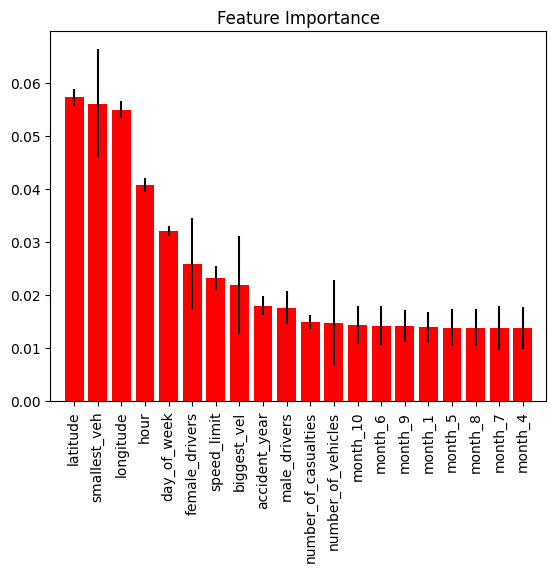

In [23]:
skplt.estimators.plot_feature_importances(rf_best, feature_names= list(X_train.columns))
plt.xticks(rotation=90)

##Using RF with classweight directly

In [24]:
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xc_train_us
y_train=yc_train_us
X_test=Xc_val
y_test=yc_val

# Define the F1 score scorer for the 'Major' class
scorer = make_scorer(f1_score, pos_label='Major')
scorers = {
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score),
}
# ...

rf_imbal = RandomForestClassifier(class_weight='balanced')
parameters_rf = {
    'n_estimators': [300, 200],
    'criterion': ["gini"], # "entropy"],
    'max_depth': [50,100],# 12],
    'max_features': ['sqrt']#,'log2']
}
rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorers, n_jobs=-1, refit='f1_score')  #using accuracy

#rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorer, n_jobs=-1)
t0 = time.time()
rf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", rf_clf.best_params_)

cv_results = rf_clf.cv_results_

# Print the scores for each hyperparameter combination
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))


rf_best = rf_clf.best_estimator_



rf_best = rf_clf.best_estimator_


It takes 870.429 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 300}
Hyperparameters: {'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 300}
   f1_score: 0.660 (+/-0.002)
   precision: 0.646 (+/-0.004)
   recall: 0.675 (+/-0.005)
   accuracy: 0.652 (+/-0.003)
   auc: 0.652 (+/-0.003)
   auprc: 0.598 (+/-0.003)
Hyperparameters: {'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 200}
   f1_score: 0.659 (+/-0.001)
   precision: 0.646 (+/-0.004)
   recall: 0.672 (+/-0.003)
   accuracy: 0.652 (+/-0.003)
   auc: 0.652 (+/-0.003)
   auprc: 0.598 (+/-0.003)
Hyperparameters: {'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 300}
   f1_score: 0.660 (+/-0.002)
   precision: 0.646 (+/-0.005)
   recall: 0.676 (+/-0.003)
   accuracy: 0.652 (+/-0.003)
   auc: 0.652 (+/-0.003)
   auprc: 0.598 (+/-0.003)
Hyperparameters: {'criterion': 'gini', 'max_depth

In [25]:
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"rf_cwbc_{timestamp}.pkl"
print(file_name)
with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(rf_best, file)


rf_cwbc_072118.pkl


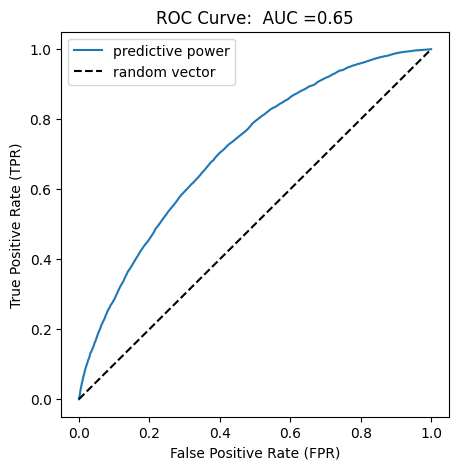

              precision    recall  f1-score   support

           0       0.86      0.63      0.73     27316
           1       0.35      0.67      0.46      8148

    accuracy                           0.64     35464
   macro avg       0.61      0.65      0.60     35464
weighted avg       0.75      0.64      0.67     35464



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,17249,10067
Actual Major_Acc,2693,5455


In [26]:
# saved model rf_cwbc_072118.pkl


matrix, report = evaluate_classifier(rf_best, X_test, y_test)
matrix

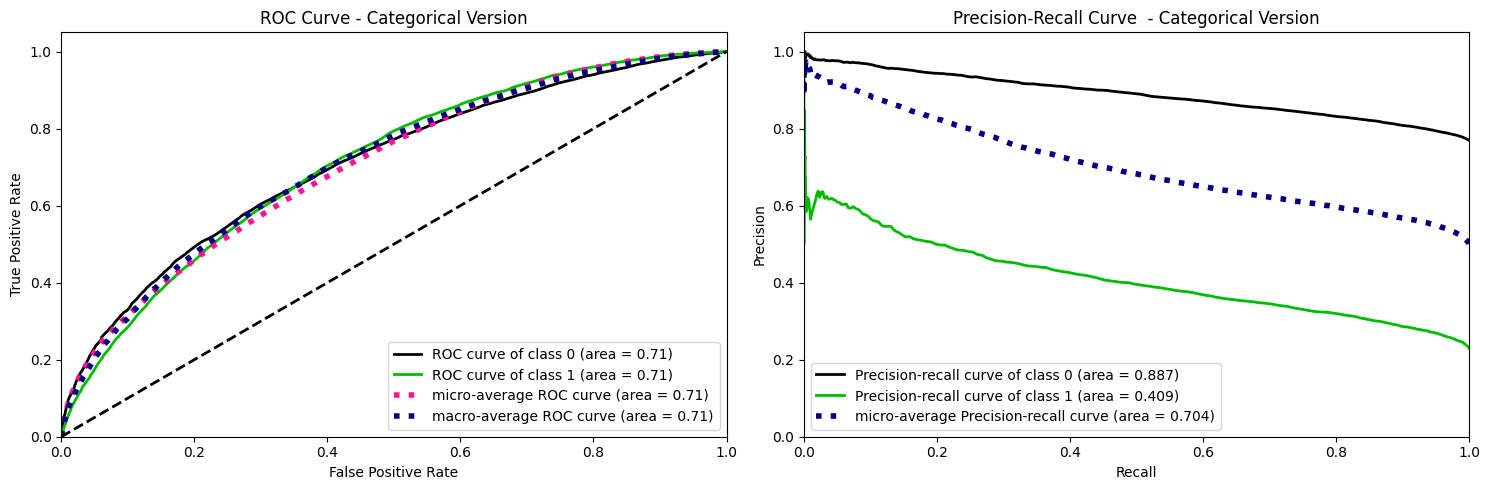

AUC score:  0.7102609494522659         AUPRC score:  0.40941209100589926


(0.7102609494522659, 0.40941209100589926)

In [28]:
ROC_PRC(rf_best, X_test, y_test)

In [27]:
rf_clf.cv_results_

{'mean_fit_time': array([91.31750593, 60.49044266, 90.58566394, 62.45423789]),
 'std_fit_time': array([0.39364472, 1.09906777, 1.21269552, 2.74004908]),
 'mean_score_time': array([3.50476475, 2.38842602, 3.76306987, 2.16141019]),
 'std_score_time': array([0.78756543, 0.66425371, 0.58658544, 0.37726803]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[50, 50, 100, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['sqrt', 'sqrt', 'sqrt', 'sqrt'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[300, 200, 300, 200],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterio

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'latitude'),
  Text(1, 0, 'longitude'),
  Text(2, 0, 'hour'),
  Text(3, 0, 'month'),
  Text(4, 0, 'police_force'),
  Text(5, 0, 'day_of_week'),
  Text(6, 0, 'smallest_veh'),
  Text(7, 0, 'junction_location'),
  Text(8, 0, 'junction_detail'),
  Text(9, 0, 'first_road_class'),
  Text(10, 0, 'speed_limit'),
  Text(11, 0, 'accident_year'),
  Text(12, 0, 'time_of_day'),
  Text(13, 0, 'biggest_vel'),
  Text(14, 0, 'number_of_casualties'),
  Text(15, 0, 'weather_conditions'),
  Text(16, 0, 'number_of_vehicles'),
  Text(17, 0, 'male_drivers'),
  Text(18, 0, 'pedestrian_crossing_physical_facilities'),
  Text(19, 0, 'road_type')])

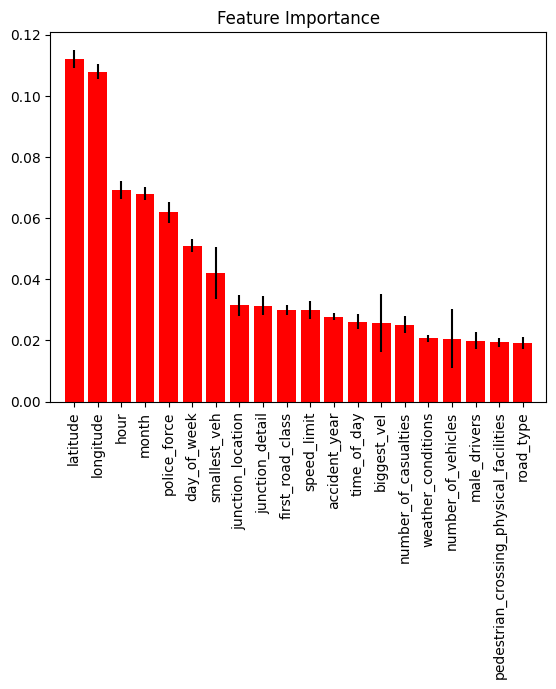

In [29]:
skplt.estimators.plot_feature_importances(rf_best, feature_names= list(X_train.columns))
plt.xticks(rotation=90)

##Using RF with classweight directly on encoded categories

In [30]:
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xe_train_us
y_train=ye_train_us
X_test=Xe_val
y_test=ye_val

# Define the F1 score scorer for the 'Major' class
scorer = make_scorer(f1_score, pos_label='Major')
scorers = {
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score),
}
# ...

rf_imbal = RandomForestClassifier(class_weight='balanced')
parameters_rf = {
    'n_estimators': [300],# 200],
    'criterion': ["gini"], # "entropy"],
    'max_depth': [100],#50],# 12],
    'max_features': ['sqrt']#,'log2']
}
rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorers, n_jobs=-1, refit='f1_score')  #using accuracy

#rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorer, n_jobs=-1)
t0 = time.time()
rf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", rf_clf.best_params_)

cv_results = rf_clf.cv_results_

# Print the scores for each hyperparameter combination
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))


rf_best = rf_clf.best_estimator_


It takes 493.983 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 300}
Hyperparameters: {'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 300}
   f1_score: 0.660 (+/-0.003)
   precision: 0.646 (+/-0.005)
   recall: 0.674 (+/-0.006)
   accuracy: 0.652 (+/-0.004)
   auc: 0.652 (+/-0.004)
   auprc: 0.598 (+/-0.003)


In [31]:
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"rf_cwbe_{timestamp}.pkl"
print(file_name)
with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(rf_best, file)


rf_cwbe_072118.pkl


In [40]:
# load the model filename=?   # saved model rf_uc_072110.pkl
file_name = "rf_cwbe_072118.pkl"

#define dataset as training and validation of undersampling categorical dataframe
X_train=Xe_train_us
y_train=ye_train_us
X_test=Xe_val
y_test=ye_val

with open("./drive/MyDrive/Accidents/Data/"+file_name, 'rb') as file:
    rf_best = pickle.load(file)

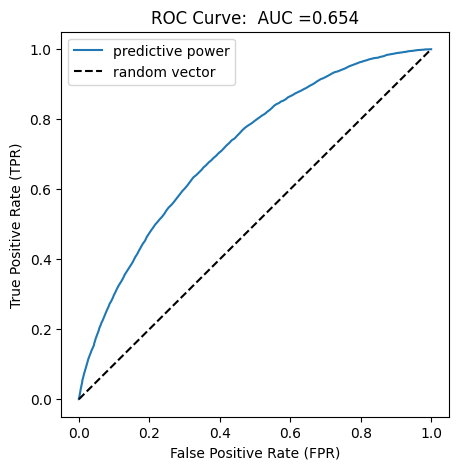

              precision    recall  f1-score   support

           0       0.87      0.64      0.74     27316
           1       0.36      0.67      0.46      8148

    accuracy                           0.65     35464
   macro avg       0.61      0.65      0.60     35464
weighted avg       0.75      0.65      0.67     35464



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,17453,9863
Actual Major_Acc,2700,5448


In [32]:
# saved model rf_cwbe_072118.pkl


matrix, report = evaluate_classifier(rf_best, X_test, y_test)
matrix

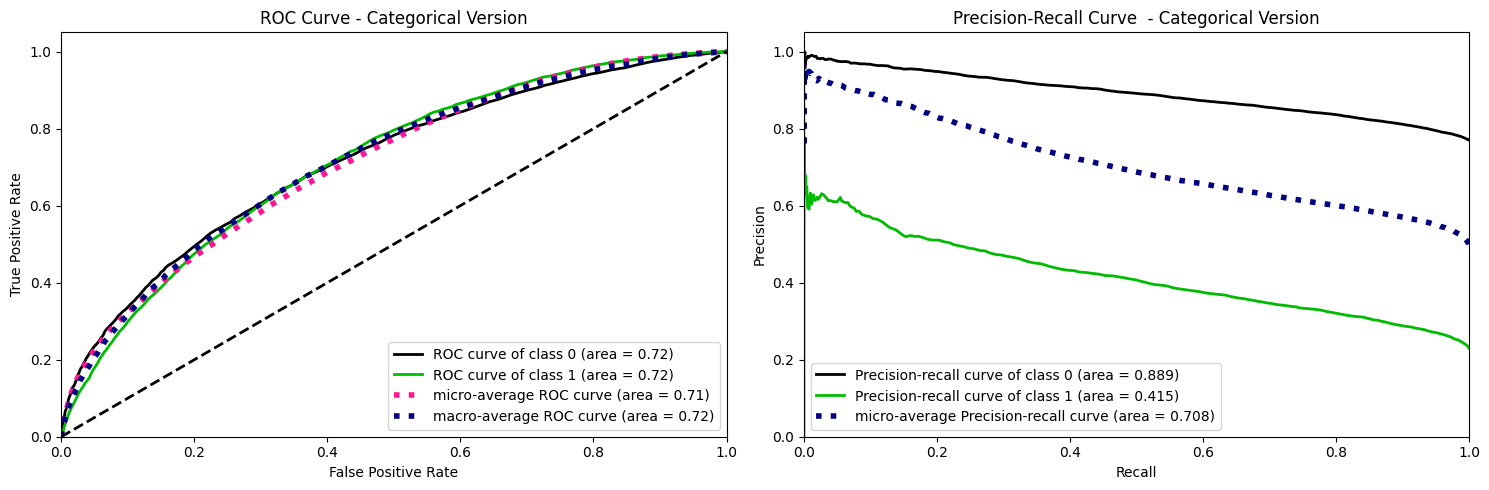

AUC score:  0.7150934910733651         AUPRC score:  0.41483591295847666


(0.7150934910733651, 0.41483591295847666)

In [33]:
ROC_PRC(rf_best, X_test, y_test)

In [34]:
rf_clf.cv_results_

{'mean_fit_time': array([129.02204576]),
 'std_fit_time': array([20.76753738]),
 'mean_score_time': array([4.81599936]),
 'std_score_time': array([1.03066211]),
 'param_criterion': masked_array(data=['gini'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['sqrt'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[300],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini',
   'max_depth': 100,
   'max_features': 'sqrt',
   'n_estimators': 300}],
 'split0_test_f1_score': array([0.66291359]),
 'split1_test_f1_score': array([0.657173]),
 'split2_test_f1_score': array([0.65932914]),
 'split3_test_f1_score': array([0.6556341]),
 'split4_test_f1_score': array([0.6630

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'latitude'),
  Text(1, 0, 'longitude'),
  Text(2, 0, 'hour'),
  Text(3, 0, 'day_of_week'),
  Text(4, 0, 'smallest_veh'),
  Text(5, 0, 'speed_limit'),
  Text(6, 0, 'biggest_vel'),
  Text(7, 0, 'accident_year'),
  Text(8, 0, 'number_of_casualties'),
  Text(9, 0, 'number_of_vehicles'),
  Text(10, 0, 'male_drivers'),
  Text(11, 0, 'female_drivers'),
  Text(12, 0, 'covid'),
  Text(13, 0, 'did_police_officer_attend_scene_of_accident'),
  Text(14, 0, 'first_road_class_3'),
  Text(15, 0, 'first_road_class_6'),
  Text(16, 0, 'weekend'),
  Text(17, 0, 'time_of_day_3'),
  Text(18, 0, 'skidding'),
  Text(19, 0, 'urban_or_rural_area')])

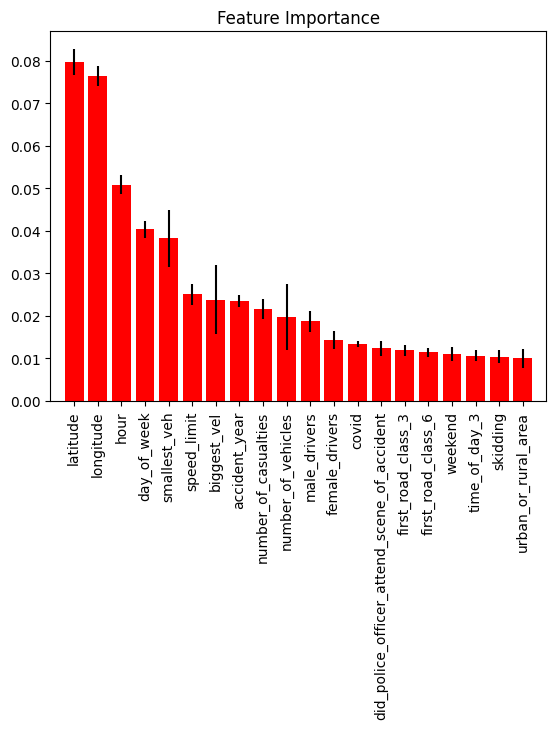

In [35]:
skplt.estimators.plot_feature_importances(rf_best, feature_names= list(X_train.columns))
plt.xticks(rotation=90)

###Next Step : Check for overfitting and run various other models too

In [ ]:
#Sample Run Steps

In [ ]:
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xe_train_us
y_train=ye_train_us
X_test=Xe_val
y_test=ye_val

# Define the F1 score scorer for the 'Major' class
scorer = make_scorer(f1_score, pos_label='Major')
scorers = {
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score),
}
# ...

rf_imbal = RandomForestClassifier(class_weight='balanced')
parameters_rf = {
    'n_estimators': [300],# 200],
    'criterion': ["gini"], # "entropy"],
    'max_depth': [100],#50],# 12],
    'max_features': ['sqrt']#,'log2']
}
rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorers, n_jobs=-1, refit='f1_score')  #using accuracy

#rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorer, n_jobs=-1)
t0 = time.time()
rf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", rf_clf.best_params_)

cv_results = rf_clf.cv_results_

# Print the scores for each hyperparameter combination
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))


rf_best = rf_clf.best_estimator_


In [ ]:
rf_clf.cv_results_

In [ ]:
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"rf_cwbe_{timestamp}.pkl"
print(file_name)
with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(rf_best, file)


In [ ]:
# load the model filename=?   # saved model rf_uc_072110.pkl
file_name = "rf_uc_072110.pkl"
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xc_train_us
y_train=yc_train_us
X_test=Xc_val
y_test=yc_val

with open("./drive/MyDrive/Accidents/Data/"+file_name, 'rb') as file:
    rf_best = pickle.load(file)

In [ ]:
#check performance on train set !!!
matrix, report = evaluate_classifier(rf_best, X_train, y_train)
matrix

In [ ]:
matrix, report = evaluate_classifier(rf_best, X_test, y_test)
matrix

In [ ]:
ROC_PRC(rf_best, X_test, y_test)

In [ ]:
skplt.estimators.plot_feature_importances(rf_best, feature_names= list(X_train.columns))
plt.xticks(rotation=90)